In [1]:
import os
import copy
import numpy as np
import torch
import einops
import pdb
import ipdb
from diffuser.utils.arrays import batch_to_device, to_np, to_device, apply_dict
from IPython.display import clear_output
import time

pybullet build time: May 20 2022 19:44:17


In [2]:
import diffuser.utils as utils

In [3]:
diffusion = utils.load_diffusion('../logs', 
                                 'maze2d-large-v1', 
                                 'diffusion/H384_T256_20231031-1406', 
                                 epoch='latest')
clear_output()

0.6232748031616211
Saved 1 samples to: tmp.png


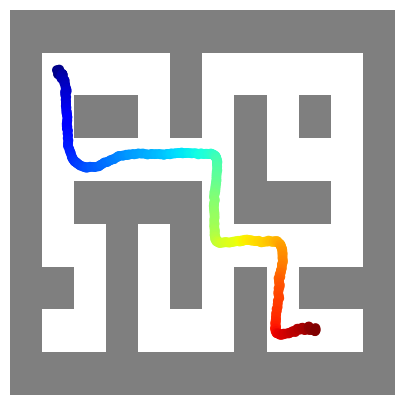

In [6]:
cond = {0: [1, 1, 0, 0], 383: [7, 9, 0, 0]}
# cond = [[1, 1, 0, 0], [7, 9, 0, 0]]

cond = utils.apply_dict(
    diffusion.dataset.normalizer.normalize,
    cond,
    'observations'
)
cond = utils.to_torch(cond, dtype=torch.float32, device='cuda:0')
cond = utils.apply_dict(
    einops.repeat,
    cond,
    'd -> repeat d', repeat=1,
)
start = time.time()
samples = diffusion.ema.conditional_sample(cond)
end = time.time()
print(end-start)
samples = to_np(samples)
normed_observations = samples[:, :, 2:]
normed_conditions = to_np(cond[0])[:,None]
normed_observations = np.concatenate([
    np.repeat(normed_conditions, 1, axis=0),
    normed_observations
    ], axis=1)
observations = diffusion.dataset.normalizer.unnormalize(normed_observations, 'observations')
images = diffusion.renderer.composite('tmp.png', observations, ncol=1)